In [13]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
import numpy as np
import yfinance as yf
import functions as f


%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


[nltk_data] Downloading package stopwords to C:\Users\Kwan Yui
[nltk_data]     Yang\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\Kwan Yui
[nltk_data]     Yang\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Data Prepcocessing

In [14]:
tickerlist = ['BTC-USD']
df = yf.download(tickerlist, period = '1d', start = '2007-01-01',end = pd.Timestamp.today())
columns = tickerlist
df = df.iloc[:,4]['2019':]
df.head()

[*********************100%***********************]  1 of 1 completed


Date
2019-01-01    3843.520020
2019-01-02    3943.409424
2019-01-03    3836.741211
2019-01-04    3857.717529
2019-01-05    3845.194580
Name: Adj Close, dtype: float64

In [15]:
df = pd.DataFrame(df).pct_change().dropna()
df.index = df.index.astype(str)
df['Adj Close'] = df['Adj Close']
df['date'] = df.index

## Import backtest results generated from Model.ipynb

In [16]:
bt = pd.read_csv('final_btc_backtest_monitored.csv',index_col = 0)
bt['ensemble'] = bt.sum(axis =1)
bt['ensemble'] = list(map(f.major_vote,bt['ensemble']))
bt = bt[['ensemble']]
bt.columns = ['BTC-USD']
bt['BTC-USD'] = [1 if x == 1 else -1 for x in bt['BTC-USD']]
bt.index = bt.index.astype(str)
bt_returns = bt[['BTC-USD']]
bt_returns['date'] = bt_returns.index
bt_returns

,BTC-USD,date
2020-01-31,1,2020-01-31
2020-02-01,1,2020-02-01
2020-02-02,1,2020-02-02
2020-02-03,1,2020-02-03
2020-02-04,1,2020-02-04
...,...,...
2022-04-07,-1,2022-04-07
2022-04-08,1,2022-04-08
2022-04-09,1,2022-04-09
2022-04-10,1,2022-04-10


## The 'BTC-USD' Column indicates whether we the model predicts if btc is going up or down:
1. -1 => BTC going down => Short
2. 1 => BTC going up => Long
3. Transform the returns by multiplying the returns column by 1 or -1 to get te returns of the model
4. Perfrom df.cumprod() function to get the compounded returns

In [17]:
bt_returns = pd.read_csv('final_btc_backtest_monitored.csv', index_col = 0)
bt_returns['ensemble'] = bt_returns.sum(axis=1)
bt_returns['date'] = bt_returns.index
bt_returns['ensemble'] = bt_returns.ensemble.apply(f.major_vote)
bt_returns

,BTC-USD,BTC-USD.1,BTC-USD.2,ensemble,date
2020-01-31,1,1,1,1,2020-01-31
2020-02-01,1,1,1,1,2020-02-01
2020-02-02,1,1,1,1,2020-02-02
2020-02-03,1,1,1,1,2020-02-03
2020-02-04,1,1,1,1,2020-02-04
...,...,...,...,...,...
2022-04-07,1,0,0,0,2022-04-07
2022-04-08,1,0,1,1,2022-04-08
2022-04-09,1,1,0,1,2022-04-09
2022-04-10,1,1,0,1,2022-04-10


In [18]:
bt_returns['date'] = pd.to_datetime(bt_returns.date.values).strftime('%Y-%m-%d')
bt_returns

,BTC-USD,BTC-USD.1,BTC-USD.2,ensemble,date
2020-01-31,1,1,1,1,2020-01-31
2020-02-01,1,1,1,1,2020-02-01
2020-02-02,1,1,1,1,2020-02-02
2020-02-03,1,1,1,1,2020-02-03
2020-02-04,1,1,1,1,2020-02-04
...,...,...,...,...,...
2022-04-07,1,0,0,0,2022-04-07
2022-04-08,1,0,1,1,2022-04-08
2022-04-09,1,1,0,1,2022-04-09
2022-04-10,1,1,0,1,2022-04-10


In [19]:
df = df.merge(bt_returns, on = 'date', how = 'right')
df = df[['Adj Close','ensemble','date']]
df.columns = ['Adj Close','BTC-USD','date']

In [20]:
df.set_index('date',inplace = True)

In [21]:
df.head()

,Adj Close,BTC-USD
date,,
2020-01-31,-0.016665,1
2020-02-01,0.004529,1
2020-02-02,-0.005165,1
2020-02-03,-0.005441,1
2020-02-04,-0.012112,1


In [22]:
df['Passive Hold Strategy'] = df['Adj Close']
df['NLP Trading Strategy'] = df['BTC-USD'] * df['Adj Close']
df = df[['Passive Hold Strategy','NLP Trading Strategy']]
df.head()

,Passive Hold Strategy,NLP Trading Strategy
date,,
2020-01-31,-0.016665,-0.016665
2020-02-01,0.004529,0.004529
2020-02-02,-0.005165,-0.005165
2020-02-03,-0.005441,-0.005441
2020-02-04,-0.012112,-0.012112


In [23]:
returns = 100*((1+df).cumprod())-100
returns.head()

,Passive Hold Strategy,NLP Trading Strategy
date,,
2020-01-31,-1.666463,-1.666463
2020-02-01,-1.221140,-1.221140
2020-02-02,-1.731287,-1.731287
2020-02-03,-2.265978,-2.265978
2020-02-04,-3.449685,-3.449685


## Backtest results from start of 2021 to now

Text(0, 0.5, 'Compounded Returns (%)')

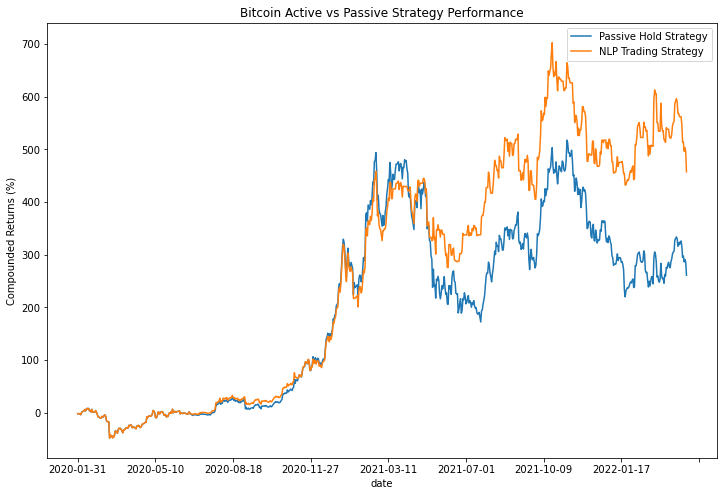

In [24]:
returns.plot(figsize = (12,8), title = 'Bitcoin Active vs Passive Strategy Performance')
plt.ylabel('Compounded Returns (%)')